In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymodulon.io import load_json_model
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
import shap
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

sys.path.append('bitome2')
sys.path.append('')

from bitome.core import Bitome
from bitome.ml import *

sns.set_style('whitegrid')

shap.initjs()

In [2]:
K12_DATA_PATH = Path('data/bitome2/mg1655')

In [3]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [4]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

# TU table

In [5]:
bitome_genbank = Bitome('NC_000913.3.gb')
tu_table = pd.read_csv('TU_table.csv')

In [7]:
tu_table = tu_table.set_index('locus_tag')
tu_table

,Unnamed: 0,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,,
ECK120008913,0,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
ECK120008914,1,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
ECK120008915,2,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0
ECK120008916,3,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0
ECK120008917,4,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,4105785.0,4106379.0
...,...,...,...,...,...,...,...,...,...,...,...
ECK125285343,3668,argH,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4156850.0,4158223.0
ECK125285344,3669,aroD,1.0,1774571.0,Sigma70,1774561.0,1774566.0,1774535.0,1774540.0,1774571.0,1775444.0
ECK125285345,3670,yihUTS,-1.0,4073606.0,Sigma70,NaN,NaN,NaN,NaN,4070515.0,4073606.0


# Frequency distributions

In [8]:
tss_box_10 =[]
box_10_len = []
spacer = []
box_35_len = []

for index, row in tu_table.iterrows():
    tss, box_10_left, box_10_right, box_35_left, box_35_right, strand = row['tss'], row['box_10_left'], row['box_10_right'], row['box_35_left'], row['box_35_right'], row['strand']

    if strand == 1:
        
        tss_box_10.append(tss - box_10_right)
        box_10_len.append(box_10_right - box_10_left)
        spacer.append(-box_35_right + box_10_left)
        box_35_len.append(box_35_right - box_35_left)
        
    elif strand == -1:
        
        tss_box_10.append(box_10_left - tss)
        box_10_len.append(box_10_right - box_10_left)
        spacer.append(box_35_left - box_10_right)
        box_35_len.append(box_35_right - box_35_left)
        
    else:
        
        tss_box_10.append(0)
        box_10_len.append(0)
        spacer.append(0)
        box_35_len.append(0)

Text(0, 0.5, 'Frequency')

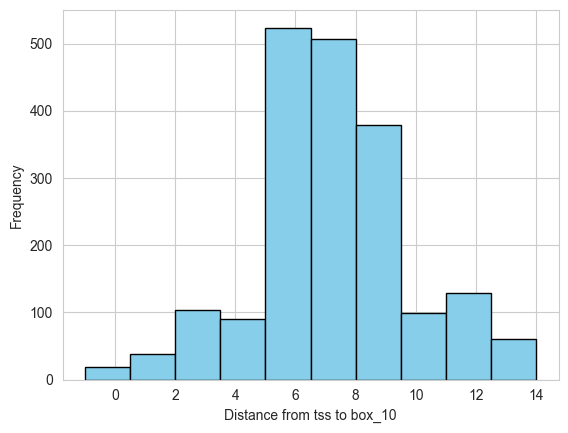

In [9]:
plt.hist(tss_box_10, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Distance from tss to box_10')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

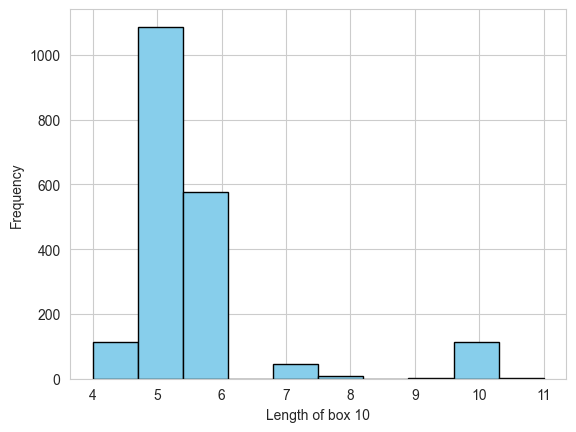

In [10]:
plt.hist(box_10_len, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Length of box 10')
plt.ylabel('Frequency')


Text(0, 0.5, 'Frequency')

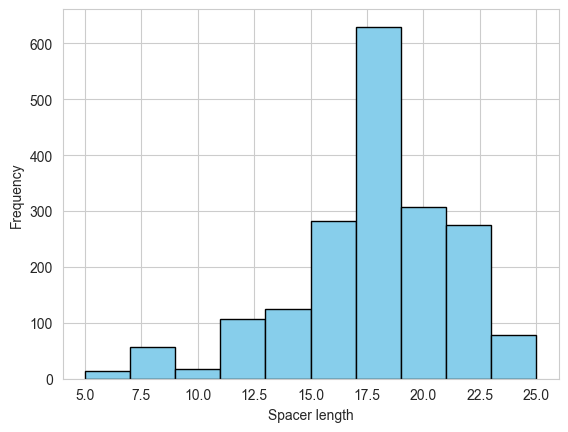

In [11]:
plt.hist(spacer, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Spacer length')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

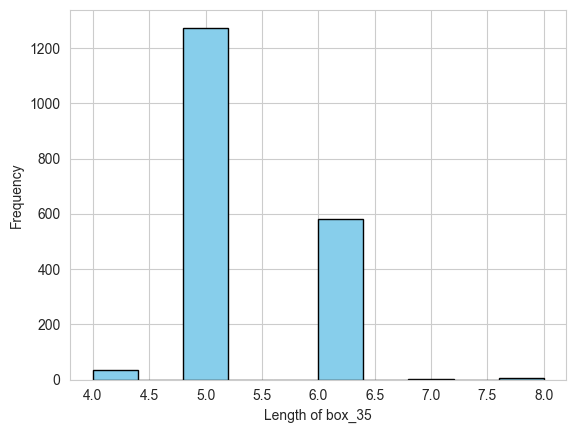

In [12]:
plt.hist(box_35_len, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Length of box_35')
plt.ylabel('Frequency')

### OHE

In [43]:
one_hot_tus = mg1655.one_hot_encode_tu_promoters(n_upstream=50, n_downstream=10)

In [15]:
def one_hot_encode_sequence(left: int, right: int, strand: int) -> pd.Series:
    
        sequence = bitome_genbank.get_sequence(left, right, strand)
        one_hot_names = []
        one_hots = []
        for i, seq_base in enumerate(sequence):
            for base in 'ACGT':
                one_hot_names.append(f'{i}_{base}')
                if base == seq_base:
                    one_hots.append(1)
                else:
                    one_hots.append(0)

        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
        return one_hot_sequence

In [18]:
def reindex_one_hot(old_names, upstream, downstream, prefix=''):
    new_names = []
    for old_name,j in zip(old_names, [x for x in range(-upstream, downstream+1) for _ in range(4)]):
        ind, base = old_name.split('_')
        new_ind = j
        new_name = f'{prefix}{new_ind}_{base}'
        new_names.append(new_name)
    return new_names

### Spacer functions

In [16]:
def one_hot_sequence_left_padding(left: int) -> pd.Series:
    if left == 0:
        return pd.Series()
    
    one_hot_names = []
    one_hots = [] 
    for i in range(1,left+1):
        for base in ('ACGT'):
            one_hots.append(0)
            one_hot_names.append(f'{0-i}_{base}')
        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
    return one_hot_sequence

In [17]:
def one_hot_sequence_right_padding(right: int, spacer_len_oh: int) -> pd.Series:
    if right == 0:
        return pd.Series()
    
    one_hot_names = []
    one_hots = [] 
    for i in range(1,right+1):
        for base in ('ACGT'):
            one_hots.append(0)
            one_hot_names.append(f'{(int(spacer_len_oh/4)-1)+i}_{base}')
        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
    return one_hot_sequence

In [19]:
def reindex_one_hot_spacer(old_names, upstream, downstream, strand, prefix=''):
    new_names = []
    for old_name,j in zip(old_names, [x for x in range(-upstream, downstream+1) for _ in range(4)][::-1]):
        ind, base = old_name.split('_')
        new_ind = j
        new_name = f'{prefix}{new_ind}_{base}'
        new_names.append(new_name)
    return new_names

In [21]:
def generate_spacer_one_hot(tu_row):
    spacer_u, spacer_d = (tu_row.box_35_right+1, tu_row.box_10_left-1) if tu_row.strand == 1 else (
    tu_row.box_10_right+1, tu_row.box_35_left-1)
    spacer_oh = one_hot_encode_sequence(spacer_u, spacer_d, tu_row.strand)
    
    length = len(spacer_oh) // 4
    if length % 2 == 0:
        left = int((26 - length) / 2)
        right = int((26 - length) / 2)
    else:
        left = int((26 - length) / 2)
        right = int((26 - length) // 2) + 1
    spacer_ohh = pd.concat([one_hot_sequence_left_padding(left=left), spacer_oh,
                               one_hot_sequence_right_padding(right=right, spacer_len_oh=length)])

    return spacer_ohh

### MR OHE

In [24]:
tu = tu_table
def one_hot_encode_tu_promoters(local_align: bool = False,
                                    upstream: int = 0, downstream: int = 0,
                                    box_10_l: bool = False, box_10_r: bool = False,
                                    box_35_l: bool = False, box_35_r: bool = False, 
                                    tss: bool = False, tfbs_l: bool = False, tfbs_r: bool = False, spacer: bool = False,
                                    tss_up: int = 0, tss_dn: int = 0,
                                    box_10_l_up: int = 0, box_10_l_dn: int = 0,
                                    box_10_r_up: int = 0, box_10_r_dn: int = 0,
                                    box_35_l_up: int = 0, box_35_l_dn: int = 0,
                                    box_35_r_up: int = 0, box_35_r_dn: int = 0,
                                    ) -> pd.DataFrame:
    
        #Change this according to the dataframe
        tu_table = tu
        
        a = []
        tss_oh, box_10_l_oh, box_10_r_oh, box_35_l_oh, box_35_r_oh, spacer_ohh = [None] * 6
        
        if local_align:
            one_hot_index = []
            one_hot_rows = []
            tu_table_local_align = tu_table[
                (tu_table['tss'].notna()) &
                (tu_table['box_10_left'].notna()) &
                (tu_table['box_35_left'].notna())
            ]
            
            for tu_row in tu_table_local_align.itertuples():
                if spacer:
                    spacer_ohh = generate_spacer_one_hot(tu_row)
                    spacer_ohh.index = reindex_one_hot_spacer(spacer_ohh.index, 0, 25, strand = tu_row.strand, prefix='spacer_')
                
                if tss:
                    if tu_row.strand == 1:
                        tss_u, tss_d = tu_row.tss - tss_up, tu_row.tss + tss_dn
                    else:
                        tss_u, tss_d = tu_row.tss - tss_dn, tu_row.tss + tss_up
                    tss_oh = one_hot_encode_sequence(tss_u, tss_d, tu_row.strand)
                    tss_oh.index = reindex_one_hot(tss_oh.index, tss_up, tss_dn, prefix='tss_')
                        
                if box_10_l:
                    if tu_row.strand == 1:
                        box_10_l_u, box_10_l_d = tu_row.box_10_left - box_10_l_up, tu_row.box_10_left + box_10_l_dn
                    else:
                        box_10_l_u, box_10_l_d = tu_row.box_10_left - box_10_l_dn, tu_row.box_10_left + box_10_l_up
                    box_10_l_oh = one_hot_encode_sequence(box_10_l_u, box_10_l_d, tu_row.strand)
                    box_10_l_oh.index = reindex_one_hot(box_10_l_oh.index, box_10_l_up, box_10_l_dn, prefix='box_10_l_')
                           
                if box_10_r:
                    if tu_row.strand == 1:
                        box_10_r_u, box_10_r_d = tu_row.box_10_right - box_10_r_up, tu_row.box_10_right + box_10_r_dn
                    else:
                        box_10_r_u, box_10_r_d = tu_row.box_10_right - box_10_r_dn, tu_row.box_10_right + box_10_r_up
                    box_10_r_oh = one_hot_encode_sequence(box_10_r_u, box_10_r_d, tu_row.strand)
                    box_10_r_oh.index = reindex_one_hot(box_10_r_oh.index, box_10_r_up, box_10_r_dn, prefix='box_10_r_')
                                 
                if box_35_l:
                    if tu_row.strand == 1:
                        box_35_l_u, box_35_l_d = tu_row.box_35_left - box_35_l_up, tu_row.box_35_left + box_35_l_dn
                    else:
                        box_35_l_u, box_35_l_d = tu_row.box_35_left - box_35_l_dn, tu_row.box_35_left + box_35_l_up
                    box_35_l_oh = one_hot_encode_sequence(box_35_l_u, box_35_l_d, tu_row.strand)
                    box_35_l_oh.index = reindex_one_hot(box_35_l_oh.index, box_35_l_up, box_35_l_dn, prefix='box_35_l_')
                        
                if box_35_r:
                    if tu_row.strand == 1:
                        box_35_r_u, box_35_r_d = tu_row.box_35_right - box_35_r_up, tu_row.box_35_right + box_35_r_dn
                    else:
                        box_35_r_u, box_35_r_d = tu_row.box_35_right - box_35_r_dn, tu_row.box_35_right + box_35_r_up
                    box_35_r_oh = one_hot_encode_sequence(box_35_r_u, box_35_r_d, tu_row.strand)
                    box_35_r_oh.index = reindex_one_hot(box_35_r_oh.index, box_35_r_up, box_35_r_dn, prefix='box_35_r_')
                
                dfs_to_concat = [tss_oh, spacer_ohh, box_10_l_oh, box_10_r_oh, box_35_l_oh, box_35_r_oh]
                if any(df is not None for df in dfs_to_concat):
                    full_oh_row = pd.concat([df for df in dfs_to_concat if df is not None])
                
                one_hot_index.append(tu_row.Index)
                one_hot_rows.append(full_oh_row)

            one_hot_tu_df = pd.DataFrame(one_hot_rows, index=one_hot_index)

        return one_hot_tu_df

In [56]:
one_hot_tus_local = one_hot_encode_tu_promoters(local_align=True, tss =True, tss_up = 3, tss_dn = 3, box_10_l=True, box_10_l_up = 0, box_10_l_dn = 2, box_10_r=True, box_10_r_up = 2, box_10_r_dn = 2, box_35_l=True, box_35_l_up = 2, box_35_l_dn = 2, box_35_r=True, box_35_r_up = 0, box_35_r_dn = 2, spacer = True)

In [57]:
one_hot_tus_local

,tss_-3_A,tss_-3_C,tss_-3_G,tss_-3_T,tss_-2_A,tss_-2_C,tss_-2_G,tss_-2_T,tss_-1_A,tss_-1_C,...,box_35_r_0_G,box_35_r_0_T,box_35_r_1_A,box_35_r_1_C,box_35_r_1_G,box_35_r_1_T,box_35_r_2_A,box_35_r_2_C,box_35_r_2_G,box_35_r_2_T
ECK120008913,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
ECK120008914,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
ECK120008915,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
ECK120008916,0,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
ECK120008917,1,0,0,0,0,0,0,1,0,1,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ECK125257178,1,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
ECK125257179,1,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
ECK125257180,0,0,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,1,0,0,0
ECK125257181,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1,0


## ML model

In [58]:
Xy_to_try = {}

In [59]:
gene_names_avg = []
gene_oh_rows_avg = []
gene_exps_avg = []
gene_exps_avg_ctrl = []
gene_exps_avg_all = []

gene_names_1tss = []
gene_oh_rows_1tss = []
gene_exps_1tss = []
gene_exps_1tss_ctrl = []
gene_exps_1tss_all = []

gene_names_local_avg = []
gene_oh_rows_local_avg = []
gene_exps_local_avg = []
gene_exps_local_avg_ctrl = []
gene_exps_local_avg_all = []

gene_names_local_1tss = []
gene_oh_rows_local_1tss = []
gene_exps_local_1tss = []
gene_exps_local_1tss_ctrl = []
gene_exps_local_1tss_all = []

for gene_row in mg1655.gene_table.itertuples():
    
    # handle the normal 1-hot
    tus_for_gene = mg1655._gene_to_tus[gene_row.Index]
    tus_in_onehot = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus.index)]
    gene_tpm = gene_row.tpm
    gene_tpm_ctrl = gene_row.tpm_ctrl
    gene_tpm_all = gene_row.tpm_all
    if tus_in_onehot and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots = one_hot_tus.loc[tus_in_onehot, :]
        tu_one_hot_avg = tu_one_hots.mean(axis=0)
        gene_names_avg.append(gene_row.Index)
        gene_oh_rows_avg.append(tu_one_hot_avg)
        gene_exps_avg.append(gene_tpm)
        gene_exps_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_onehot) == 1:
            gene_names_1tss.append(gene_row.Index)
            gene_oh_rows_1tss.append(one_hot_tus.loc[tus_in_onehot[0]])
            gene_exps_1tss.append(gene_tpm)
            gene_exps_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_1tss_all.append(gene_tpm_all)
            
    # handle the local-aligned 1-hot
    tus_in_oh_loc = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus_local.index)]
    #print(tus_in_oh_loc)
    if tus_in_oh_loc and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots_loc = one_hot_tus_local.loc[tus_in_oh_loc, :]
        tu_one_hot_avg_loc = tu_one_hots_loc.mean(axis=0)
        gene_names_local_avg.append(gene_row.Index)
        gene_oh_rows_local_avg.append(tu_one_hot_avg_loc)
        gene_exps_local_avg.append(gene_tpm)
        gene_exps_local_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_local_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_oh_loc) == 1:
            #print(one_hot_tus_local.loc[tus_in_oh_loc[0]])
            gene_names_local_1tss.append(gene_row.Index)
            gene_oh_rows_local_1tss.append(one_hot_tus_local.loc[tus_in_oh_loc[0]])
            gene_exps_local_1tss.append(gene_tpm)
            gene_exps_local_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_local_1tss_all.append(gene_tpm_all)

X_avg = pd.DataFrame(gene_oh_rows_avg, index=gene_names_avg)
Xy_to_try['prom_avg__wt'] = (X_avg, pd.Series(gene_exps_avg, index=gene_names_avg))
Xy_to_try['prom_avg__ctrl'] = (X_avg, pd.Series(gene_exps_avg_ctrl, index=gene_names_avg))
Xy_to_try['prom_avg__all'] = (X_avg, pd.Series(gene_exps_avg_all, index=gene_names_avg))

X_1tss = pd.DataFrame(gene_oh_rows_1tss, index=gene_names_1tss)
Xy_to_try['1tss__wt'] = (X_1tss, pd.Series(gene_exps_1tss, index=gene_names_1tss))
Xy_to_try['1tss__ctrl'] = (X_1tss, pd.Series(gene_exps_1tss_ctrl, index=gene_names_1tss))
Xy_to_try['1tss__all'] = (X_1tss, pd.Series(gene_exps_1tss_all, index=gene_names_1tss))

X_local_avg = pd.DataFrame(gene_oh_rows_local_avg, index=gene_names_local_avg)
Xy_to_try['local_avg__wt'] = (X_local_avg, pd.Series(gene_exps_local_avg, index=gene_names_local_avg))
Xy_to_try['local_avg__ctrl'] = (X_local_avg, pd.Series(gene_exps_local_avg_ctrl, index=gene_names_local_avg))
Xy_to_try['local_avg__all'] = (X_local_avg, pd.Series(gene_exps_local_avg_all, index=gene_names_local_avg))

X_local_1tss = pd.DataFrame(gene_oh_rows_local_1tss, index=gene_names_local_1tss)
Xy_to_try['local_1tss__wt'] = (X_local_1tss, pd.Series(gene_exps_local_1tss, index=gene_names_local_1tss))
Xy_to_try['local_1tss__ctrl'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_ctrl, index=gene_names_local_1tss))
Xy_to_try['local_1tss__all'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_all, index=gene_names_local_1tss))

In [60]:
Xy_to_try = {
    'local_1tss__wt': Xy_to_try['local_1tss__wt'],
    'local_avg__wt': Xy_to_try['local_avg__wt']
}
Xy_to_try

{'local_1tss__wt': (       tss_-3_A  tss_-3_C  tss_-3_G  tss_-3_T  tss_-2_A  tss_-2_C  tss_-2_G  \
  b0002         0         0         1         0         0         0         1   
  b0003         0         0         1         0         0         0         1   
  b0004         0         0         1         0         0         0         1   
  b0025         0         0         1         0         1         0         0   
  b0034         0         0         0         1         1         0         0   
  ...         ...       ...       ...       ...       ...       ...       ...   
  b4388         0         0         0         1         0         0         1   
  b4389         0         0         0         1         0         0         1   
  b4392         0         0         1         0         0         1         0   
  b4393         0         0         0         1         0         0         0   
  b4396         1         0         0         0         0         0         0   
  
       

In [61]:
Xy_train, Xy_lockbox = create_train_and_lockbox_sets(Xy_to_try, random_state=42)

In [62]:
models_to_try = {
    #'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RF': RandomForestRegressor(n_jobs=4)
    #'NN': MLPRegressor()
}

SVR: local_1tss__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_1tss__wt__X_raw__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_1tss__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_1tss__wt__X_standard__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_avg__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_avg__wt__X_raw__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_avg__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_avg__wt__X_standard__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_1tss__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_1tss__wt__X_raw__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_1tss__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_1tss__wt__X_standard__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_avg__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_avg__wt__X_raw__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_avg__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_avg__wt__X_standard__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.


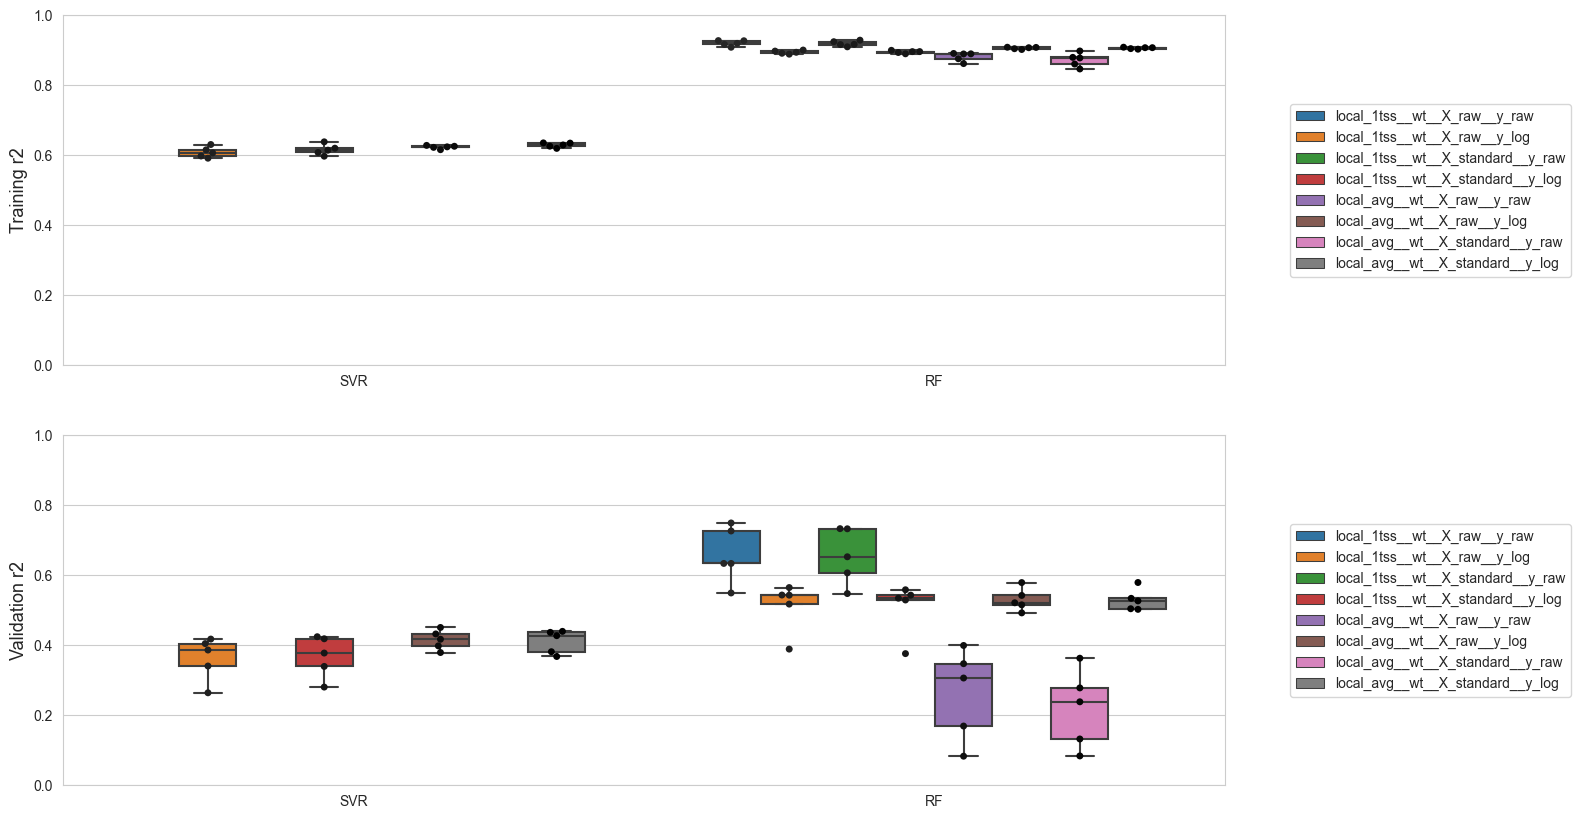

In [63]:
model_profile_df, ax_train, ax_val = profile_xy_and_models(Xy_train, models_to_try, scoring='r2', n_cv=5,
                                                           x_preprocessing=['standard'], y_preprocessing=['log'],
                                                           verbose=True)

Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.


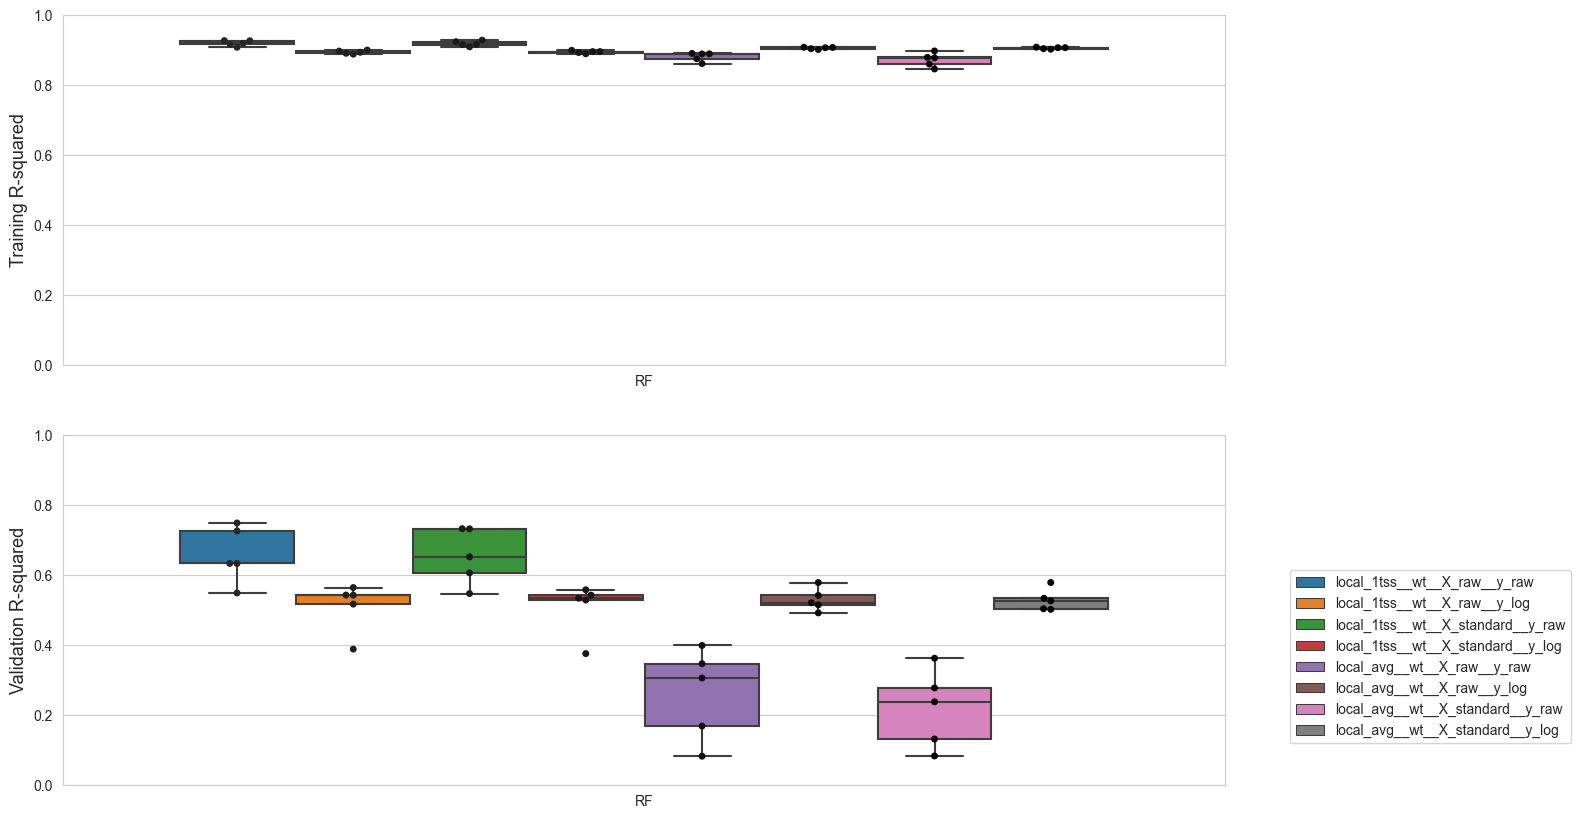

In [64]:
to_plot_df = model_profile_df[
    (model_profile_df['model'] == 'RF')
]

_, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_train)
sns.swarmplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_train)
ax_train.get_legend().remove()
ax_train.set_xlabel('')
ax_train.set_ylabel(f'Training R-squared', fontsize=13)
ax_train.set_ylim(0, 1)

sns.boxplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_val)
sns.swarmplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_val)
handles_val, labels_val = ax_val.get_legend_handles_labels()
ax_val.legend(handles_val[:int(len(handles_val)/2)], labels_val[:int(len(labels_val)/2)],
              loc='lower left', bbox_to_anchor=(1.05, 0.1))
ax_val.set_xlabel('')
ax_val.set_ylabel(f'Validation R-squared', fontsize=13)
ax_val.set_ylim(0, 1)

sns.set_style('whitegrid')

In [65]:
x_oh_fi_raw = Xy_train['local_1tss__wt'][0]
x_oh_fi_std = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw),
    columns=x_oh_fi_raw.columns,
    index=x_oh_fi_raw.index
)
y_oh_fi_raw = Xy_train['local_1tss__wt'][1]
y_oh_fi_log = np.log2(y_oh_fi_raw.values + 1)

In [66]:
x_oh_fi_raw = Xy_train['local_1tss__wt'][0]
x_oh_fi_std = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw),
    columns=x_oh_fi_raw.columns,
    index=x_oh_fi_raw.index
)
y_oh_fi_raw = Xy_train['local_1tss__wt'][1]
y_oh_fi_log = np.log2(y_oh_fi_raw.values + 1)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


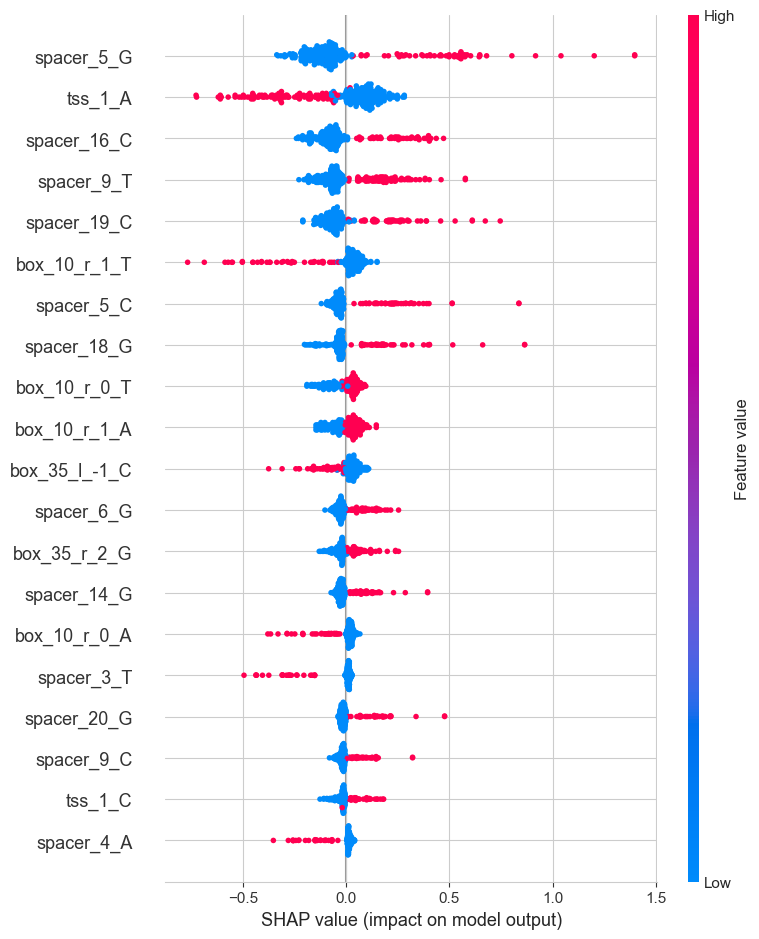

In [67]:
feature_importance(
    x_oh_fi_std,
    y_oh_fi_log,
    models_to_try['RF']
)

Text(0.5, 0.05, 'R-square: 0.78\nPearson R: 0.89 (P=3.54E-97)\nSpearman R: 0.55 (P=9.73E-24)')

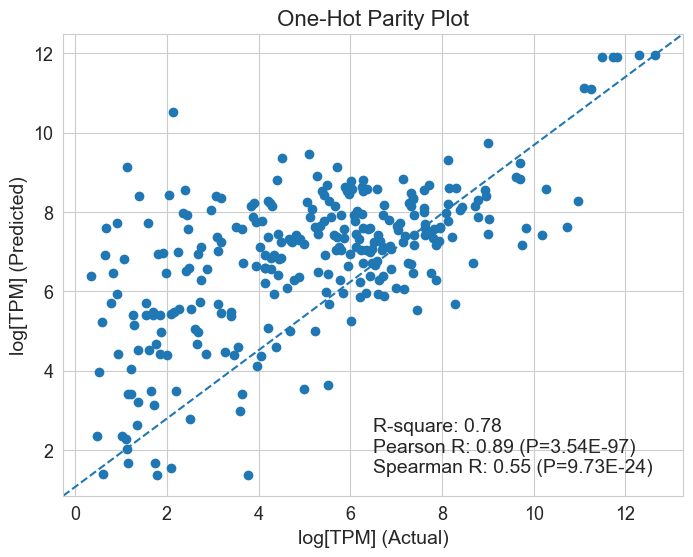

In [71]:
# split and fit the data with the given model; generate predictions
x_train, x_val, y_train, y_val = train_test_split(x_oh_fi_std, y_oh_fi_raw, test_size=0.2)
fit_model = models_to_try['RF'].fit(x_train, y_train)
y_pred = fit_model.predict(x_val)

# plot actual (x) vs predicted (y) in a parity scatterplot
y_pred_log = np.log2(y_pred + 1)
y_val_log = np.log2(y_val + 1)

r_squared = r2_score(y_val, y_pred)
pearson_r, pearson_p = pearsonr(y_val, y_pred)
spearman_r, spearman_p = spearmanr(y_val, y_pred)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val_log, y_pred_log)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('One-Hot Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)

# Grouping by transcription unit/promoter 

#### Strand = -1

In [69]:
grouped_mini_dfs = {name: group for name, group in tu_table.groupby('name')}
grouped_mini_dfs['astCADBE']

,Unnamed: 0,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,,
ECK120008913,0,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
ECK120008914,1,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
ECK120008915,2,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0


In [70]:
#change this to the promoter/TU name of choice
name_to_extract = 'astCADBE'
indexes_to_extract = grouped_mini_dfs.get(name_to_extract, pd.DataFrame()).index

result_df = one_hot_tus_local.loc[indexes_to_extract]

result_df

,tss_-3_A,tss_-3_C,tss_-3_G,tss_-3_T,tss_-2_A,tss_-2_C,tss_-2_G,tss_-2_T,tss_-1_A,tss_-1_C,...,box_35_r_0_G,box_35_r_0_T,box_35_r_1_A,box_35_r_1_C,box_35_r_1_G,box_35_r_1_T,box_35_r_2_A,box_35_r_2_C,box_35_r_2_G,box_35_r_2_T
locus_tag,,,,,,,,,,,,,,,,,,,,,
ECK120008913,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
ECK120008914,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
ECK120008915,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0


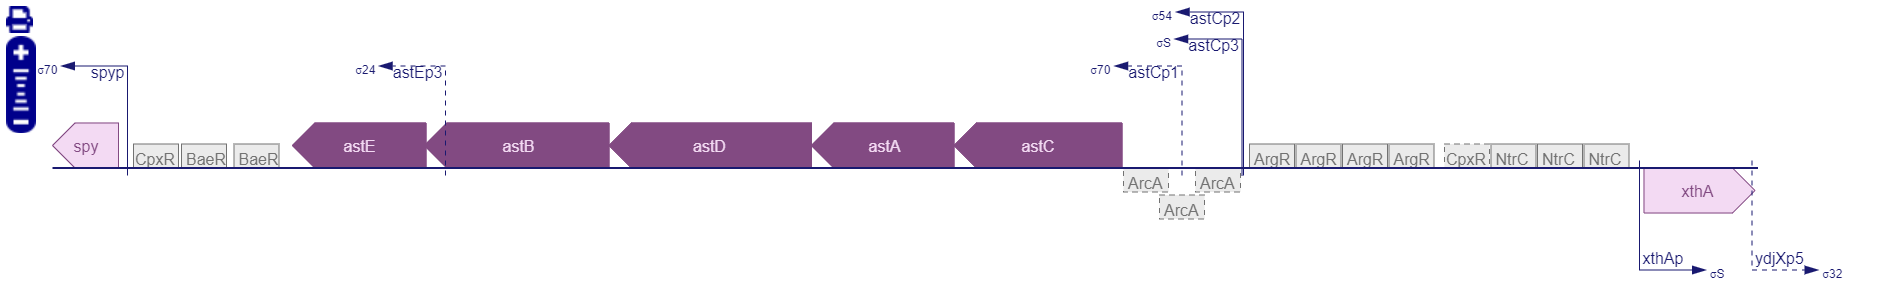

### Promoter: astCp1, tss: 1832013 

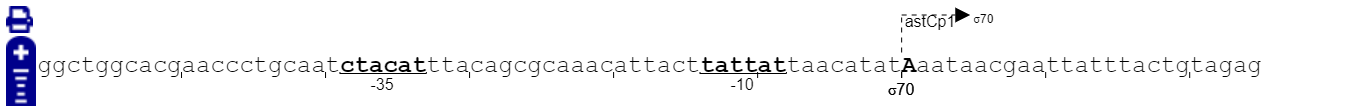

In [34]:
astCp1 = result_df.iloc[0]
filtered_values = astCp1[astCp1 == 1]
filtered_indices = filtered_values.index
for i in list(filtered_indices):
    print(i)

tss_-3_T
tss_-2_A
tss_-1_T
tss_0_A
tss_1_A
tss_2_A
tss_3_T
spacer_22_T
spacer_21_T
spacer_20_A
spacer_19_C
spacer_18_A
spacer_17_G
spacer_16_C
spacer_15_G
spacer_14_C
spacer_13_A
spacer_12_A
spacer_11_A
spacer_10_C
spacer_9_A
spacer_8_T
spacer_7_T
spacer_6_A
spacer_5_C
spacer_4_T
box_10_l_-2_T
box_10_l_-1_A
box_10_l_0_T
box_10_l_1_T
box_10_l_2_A
box_10_r_-2_C
box_10_r_-1_T
box_10_r_0_T
box_10_r_1_A
box_10_r_2_T
box_35_l_-2_C
box_35_l_-1_A
box_35_l_0_T
box_35_l_1_T
box_35_l_2_T
box_35_r_-2_A
box_35_r_-1_T
box_35_r_0_C
box_35_r_1_T
box_35_r_2_A


### Promoter: astCp2, tss: 1832044

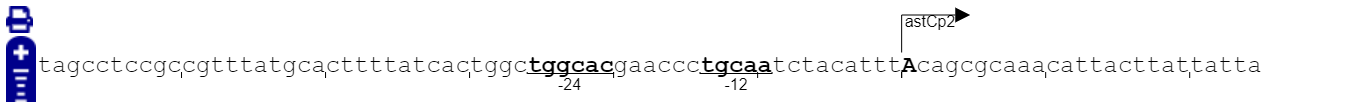

In [35]:
astCp2 = result_df.iloc[1]
filtered_values = astCp2[astCp2 == 1]
filtered_indices = filtered_values.index
for i in list(filtered_indices):
    print(i)

tss_-3_T
tss_-2_T
tss_-1_T
tss_0_A
tss_1_C
tss_2_A
tss_3_G
spacer_15_G
spacer_14_A
spacer_13_A
spacer_12_C
spacer_11_C
spacer_10_C
box_10_l_-2_C
box_10_l_-1_A
box_10_l_0_A
box_10_l_1_T
box_10_l_2_C
box_10_r_-2_C
box_10_r_-1_C
box_10_r_0_T
box_10_r_1_G
box_10_r_2_C
box_35_l_-2_C
box_35_l_-1_A
box_35_l_0_C
box_35_l_1_G
box_35_l_2_A
box_35_r_-2_G
box_35_r_-1_C
box_35_r_0_T
box_35_r_1_G
box_35_r_2_G


# Grouping by transcription unit/promoter

#### Strand = 1

In [38]:
grouped_mini_dfs = {name: group for name, group in tu_table.groupby('name')}
grouped_mini_dfs['nrdHIEF']

,Unnamed: 0,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,,
ECK120008916,3,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0


In [39]:
#change this to the promoter/TU name of choice
name_to_extract = 'nrdHIEF'
indexes_to_extract = grouped_mini_dfs.get(name_to_extract, pd.DataFrame()).index

result_df = one_hot_tus_local.loc[indexes_to_extract]

result_df

,tss_-3_A,tss_-3_C,tss_-3_G,tss_-3_T,tss_-2_A,tss_-2_C,tss_-2_G,tss_-2_T,tss_-1_A,tss_-1_C,...,box_35_r_0_G,box_35_r_0_T,box_35_r_1_A,box_35_r_1_C,box_35_r_1_G,box_35_r_1_T,box_35_r_2_A,box_35_r_2_C,box_35_r_2_G,box_35_r_2_T
locus_tag,,,,,,,,,,,,,,,,,,,,,
ECK120008916,0,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1


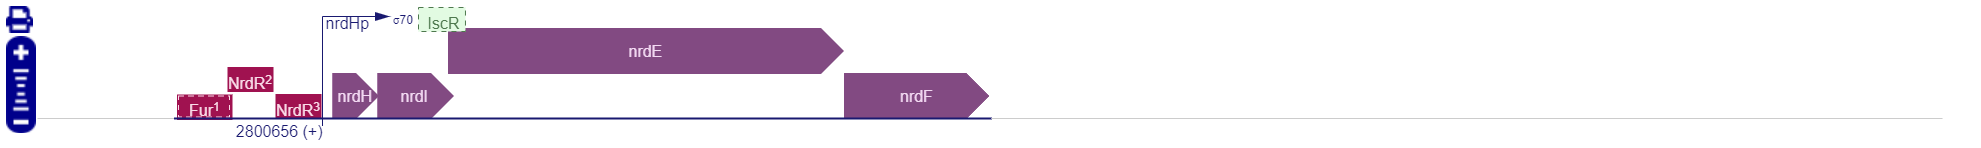

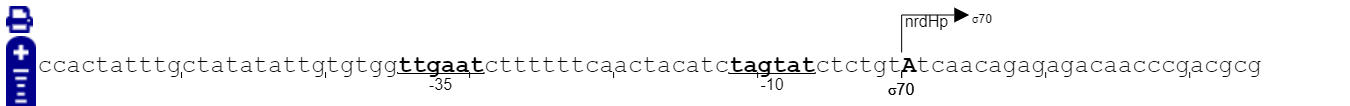

In [41]:
nrdHp = result_df.iloc[0]
filtered_values = nrdHp[nrdHp == 1]
filtered_indices = filtered_values.index
for i in list(filtered_indices):
    print(i)

tss_-3_T
tss_-2_G
tss_-1_T
tss_0_A
tss_1_T
tss_2_C
tss_3_A
spacer_21_C
spacer_20_T
spacer_19_T
spacer_18_T
spacer_17_T
spacer_16_T
spacer_15_T
spacer_14_C
spacer_13_A
spacer_12_A
spacer_11_C
spacer_10_T
spacer_9_A
spacer_8_C
spacer_7_A
spacer_6_T
spacer_5_C
box_10_l_-2_T
box_10_l_-1_C
box_10_l_0_T
box_10_l_1_A
box_10_l_2_G
box_10_r_-2_T
box_10_r_-1_A
box_10_r_0_T
box_10_r_1_C
box_10_r_2_T
box_35_l_-2_G
box_35_l_-1_G
box_35_l_0_T
box_35_l_1_T
box_35_l_2_G
box_35_r_-2_A
box_35_r_-1_A
box_35_r_0_T
box_35_r_1_C
box_35_r_2_T
